In [3]:
!pip install scikit-learn==1.3.2 numpy==1.26.4 pandas==2.1.4 pillow==9.4.0


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
%matplotlib inline

In [5]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from sklearn.utils import gen_batches

In [7]:
def plot_example(X,y):
    for i, (img,y) in enumerate(zip(X[:5].reshape(5,28,28),y[:5])):
        plt.subplot(151+i)
        plt.imshow(img, cmap = "gray")
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

X, Y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print(X.shape)
plot_example(X,Y)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)


In [8]:
X /= 255.0

In [9]:
X = np.where(X>0.5,1,0)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=10000, random_state=42, stratify=Y)

In [11]:
plot_example(X,Y)

In [16]:
class RBM:
    def __init__(self, num_hidden, num_visible):
        self.hidden_dim = num_hidden
        self.visible_dim = num_visible
        self.W = np.random.randn(num_visible,num_hidden)
        self.bh = np.random.randn(num_hidden)
        self.bv = np.random.randn(num_visible)

    def fit(self,X,epochs,batch_dim,lr):
        for epoch in range(epochs):
            self.plot_weights(step=epoch, save=True)
            epoch_error=0
            batches = list(gen_batches(X.shape[0], batch_dim))
            for i in batches:
                batch = X[i.start:i.stop]
                batch_size = batch.shape[0]
                pre_sigmoid = np.dot(batch,self.W)+self.bh
                P = np.ones((batch_size,self.hidden_dim)) / (np.ones((batch_size,self.hidden_dim))+np.exp(-pre_sigmoid))
                wake = np.dot(batch.T,P)

                pos_ones_reconstructed = np.ones((batch_size, self.visible_dim))
                reconstructed_data_probabilities = pos_ones_reconstructed / (pos_ones_reconstructed + np.exp(-np.dot(P, np.transpose(self.W))-self.bv))
                neg_ones_hidden = np.ones((batch_size, self.hidden_dim))
                negative_hidden_probabilities = neg_ones_hidden / (neg_ones_hidden + np.exp(-np.dot(reconstructed_data_probabilities,self.W)-self.bh))
                dream = np.dot(np.transpose(reconstructed_data_probabilities),negative_hidden_probabilities)

                error = np.sum((batch-reconstructed_data_probabilities)**2)/batch_size

                self.W = self.W + lr*(wake-dream)/batch_size
                self.bh += lr*(np.sum(P-negative_hidden_probabilities, axis=0))/batch_size
                self.bv += lr*(np.sum(batch-reconstructed_data_probabilities,axis=0))/batch_size

                epoch_error+=error
            
            epoch_error/=len(batches)
            print(f"epoch: {epoch}/{epochs} \t{'error:'} {epoch_error}")

    def predict_reconstruction(self,X):
        ones = np.ones((X.shape[0],self.hidden_dim))
        positive_hidden_probabilities = ones/(ones+np.exp(-np.dot(X,self.W)-self.bh))
        stochastic_probs = positive_hidden_probabilities>np.random.uniform(size=positive_hidden_probabilities.shape)

        ones_reconstruct = np.ones((X.shape[0], self.visible_dim))
        reconstruct_probabilities = ones_reconstruct/(ones_reconstruct+np.exp(-np.dot(stochastic_probs,np.transpose(self.W))-self.bv))
        return reconstruct_probabilities
    
    def plot_weights(self, title='weights', step=0, save=True):
        cols = 5
        rows = int(self.hidden_dim / cols)


        plt.clf()
        fig, axes = plt.subplots(rows, cols, figsize=(10,10))
        fig.suptitle(f"{title} step:{step}")
        for i in range(rows):
            for j in range(cols):
                axes[i, j].imshow(self.W[:,i*cols+j].reshape(28, 28), cmap='gray')
                axes[i, j].axis('off')

        plt.subplots_adjust(wspace=1, hspace=1)

        if save:
            plt.savefig(f"{title}_step_{step}.png")
        else:
            plt.show()

        plt.close()

In [17]:
# Turn off interactive mode of matplotlib to avoid showing multiple plots
plt.ioff() # Initialize RBM with 30 hidden units
rbm = RBM(num_visible=X_train.shape[1], num_hidden=30)
# Train the RBM
rbm.fit(X_train, epochs=20, batch_dim=128, lr=0.7)
# Turn interactive mode back on
plt.ion()

epoch: 0/20 	error: 52.363820557979665
epoch: 1/20 	error: 44.28929365925065
epoch: 2/20 	error: 42.61858898304952
epoch: 3/20 	error: 41.71877135903551
epoch: 4/20 	error: 41.07888561538409
epoch: 5/20 	error: 40.63305520944821
epoch: 6/20 	error: 40.30709018839055
epoch: 7/20 	error: 40.07918349798225
epoch: 8/20 	error: 39.9275364615956
epoch: 9/20 	error: 39.7693356682192
epoch: 10/20 	error: 39.654353863334094
epoch: 11/20 	error: 39.495779638848326
epoch: 12/20 	error: 39.28751598561424
epoch: 13/20 	error: 39.09812154108869
epoch: 14/20 	error: 38.917342153532374
epoch: 15/20 	error: 38.733634797521255
epoch: 16/20 	error: 38.539006979702954
epoch: 17/20 	error: 38.34270947188605
epoch: 18/20 	error: 38.217101777163194
epoch: 19/20 	error: 38.143024302414936


<Figure size 640x480 with 0 Axes>

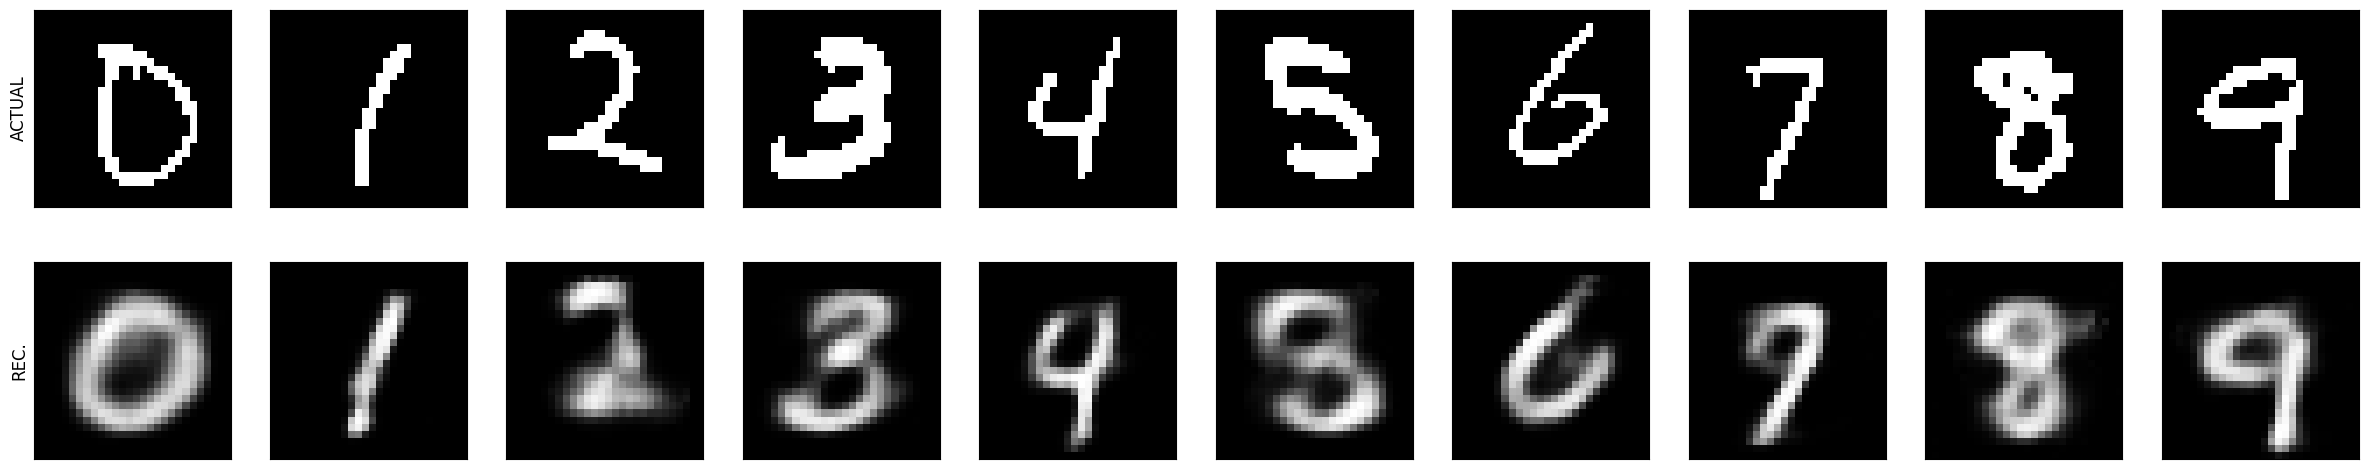

In [19]:
digit_indices = [np.where(Y_test == str(i))[0][0] for i in range(10)]
resticted_set = X_test[digit_indices]

reconstructed = rbm.predict_reconstruction(resticted_set)

# show 10 sample images
rows = 2
columns = 10

fig, axes = plt.subplots(rows, columns,sharey = True,figsize=(30, 6))
for i in range(rows):
    for j in range(columns):
        if i==0:
          axes[i, j].imshow(resticted_set[j].reshape(28, 28), cmap='gray')
        else:
          axes[i, j].imshow(reconstructed[j].reshape(28, 28), cmap='gray')

        axes[i, j].tick_params(left = False, right = False , labelleft = False,
                labelbottom = False, bottom = False)

axes[0, 0].set_ylabel("ACTUAL", fontsize=12)
axes[1, 0].set_ylabel("REC.", fontsize=12)
plt.show()